# How do crevasses change as they approach the ice front?

In [4]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


In [5]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams.update({'font.size': 16})

from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path
import multiprocessing
from functools import partial
from scipy.optimize import fminbound

import crevasse as c # main module for this project
from importlib import reload
reload(c)

<module 'crevasse' from '/home/bradlipovsky/notebooks/crevasserator/crevasse.py'>

### Define baseline parameters

In [6]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

Lcs = np.logspace(np.log10(5),np.log10(50e3),50)
r = mats['rho']/mats['rhow']

D, flexural_gravity_wavelength,lam = c.fgl(mats,geom)

In [7]:
KI_analytical, KI_analytical_bottom = c.analytical_KI(geom,mats)
KI_analytical_bending,KI_analytical_bending_bottom = c.analytical_KI_bending(geom,mats,Lcs)
geom['fl']=10
KI_analytical_foot,KI_analytical_foot_bottom = c.analytical_KI_footloose(geom,mats,Lcs)
geom['fl']=0

# Plot SIFs as a function of distance from the ice front

In [99]:
def make_flexure_plot(surface_sifs,bottom_sifs,prestress=[0,0],ylim=[-0.1,1.25]):

    haf = geom['H'] - mats['rho']/mats['rhow'] * geom['H']

    fig,ax=plt.subplots(1,2,figsize=(10,8))

    ax=plt.subplot(1,2,1)

    plt.plot([0,100e3],[0,0],'--k',label=r'$K_{II} \rightarrow 0$')
    plt.plot(geom['H']*np.ones(2),ylim,':k')
    plt.plot(flexural_gravity_wavelength*np.ones(2),ylim,':k')
    plt.plot(haf*np.ones(2),ylim,':k')
    
    plt.plot(Lcs,surface_sifs['KI']/1e6+prestress[0]/1e6,linewidth=3,
             label='$K_I$ (FEM)')
    plt.plot(Lcs,surface_sifs['KII']/1e6+prestress[1]/1e6,linewidth=3,label='$K_{II}$ (FEM)')
    
    plt.plot([0,100e3],KI_analytical*np.ones(2)/1e6,'--',label='van der Veen')
    plt.plot(Lcs,KI_analytical_bending,'--',label='$K_I$ (Beam/Buoyancy)')
    plt.plot(Lcs,KI_analytical_foot,'--',label='$K_I$ (Beam/Foot)')
    ax.set_ylim(ylim)
    ax.set_xlim([4,60e3])
    # plt.legend(loc='lower left')
    plt.xscale('log')

#     ax.text(geom['H']*1.1, 0.8, 'x = H', rotation=90)
#     ax.text(haf*1.1, 0.8, '$x = H-H_w$', rotation=90)
#     ax.text(flexural_gravity_wavelength*1.1, 0.8, 'x = $\lambda$', 
#             rotation=90)

    plt.xlabel('Crevasse distance from ice front, m')
    plt.ylabel('Stress Intensity Factor, MPa $\sqrt{m}$')
    plt.title('A. Near-front surface crevasse')

    ax=plt.subplot(1,2,2)
    
    plt.plot([0,100e3],[0,0],'--k')
    plt.plot(geom['H']*np.ones(2),ylim,':k')
    plt.plot(flexural_gravity_wavelength*np.ones(2),ylim,':k')
    plt.plot(haf*np.ones(2),ylim,':k')
    
    plt.plot(Lcs,bottom_sifs['KI']/1e6+prestress[0]/1e6,linewidth=3)
    plt.plot(Lcs,bottom_sifs['KII']/1e6+prestress[1]/1e6,linewidth=3)
    
    plt.plot([0,100e3],KI_analytical_bottom*np.ones(2)/1e6,'--')
    plt.plot(Lcs,KI_analytical_bending_bottom,'--')
    plt.plot(Lcs,KI_analytical_foot_bottom,'--')
    ax.set_ylim(ylim)
    ax.set_xlim([4,60e3])
    plt.xscale('log')
    ax.text(geom['H']*1.1, 0.8, 'x = H', rotation=90)
    ax.text(haf*1.1, 0.8, '$x = H-H_w$', rotation=90)
    ax.text(flexural_gravity_wavelength*1.1, 0.8, 'x = $\lambda$', rotation=90)
    plt.xlabel('Crevasse distance from ice front, m')
    plt.ylabel('Stress Intensity Factor, MPa $\sqrt{m}$')
    plt.title('B. Near-front bottom crevasse')

    fig.legend(loc='lower center',ncol=3)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)   
    plt.savefig('figures/sif-variation-in-x.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


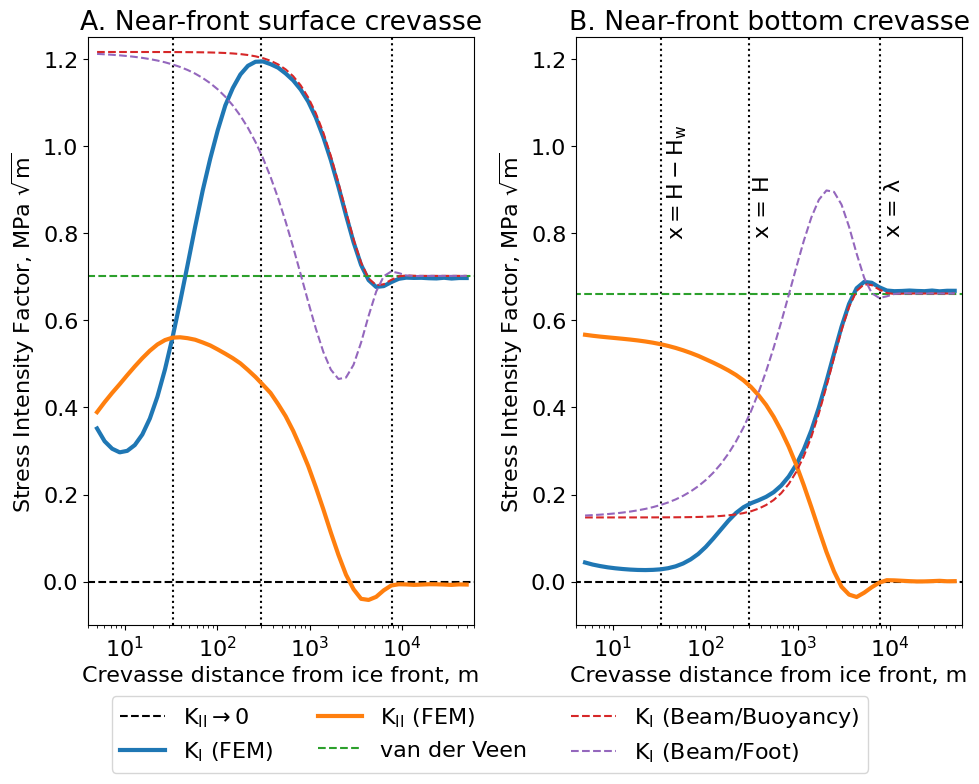

In [100]:
with open('output/sifs-surface-crevasses.pkl', 'rb') as f:
    surface_sifs = pickle.load(f)
with open('output/sifs-bottom-crevasses.pkl', 'rb') as f:
    bottom_sifs = pickle.load(f)
    
make_flexure_plot(surface_sifs,bottom_sifs)